In [1]:
from ema_workbench import (
    ScalarOutcome,
    load_results
)

from ema_workbench.util import ema_logging
from ema_workbench.analysis import parcoords

import pareto
import pandas as pd
import numpy as np
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
robustness_results = load_results('./output/robustness_experiment_results.tar.gz')
experiments, outcomes = robustness_results

In [3]:
# Separate results according to which Scenario the Policy was originally generated for
experiments['Original Scenario'] = ''
for idx, row in experiments.iterrows():
    experiments.at[idx, 'Original Scenario'] = row.policy.split('_')[0][1:]

In [4]:
experiments_by_scenario = {}
outcomes_by_scenario = {}
scenarios = np.unique(experiments['Original Scenario'])
for scenario in scenarios:
    experiments_by_scenario[scenario] = experiments[experiments['Original Scenario'] == scenario]

    indices = list(experiments_by_scenario[scenario].index)

    outcomes_by_scenario[scenario] = {}
    for key, array in outcomes.items():
        outcomes_by_scenario[scenario][key] = []

        for i in indices:
            outcomes_by_scenario[scenario][key].append(array[i])

# Policy robustness

Within this notebook we analyse robustness of policies found with directed search and further constrained according to acceptability criteria of the client. This allows for investigating robustness trade-offs as well as selecting the most robust policies.

There exists a multitude of robustness metric, stemming from the fact that there is no single definition of robustness (McPhail et al., 2018). Thus, we will analyze the policies using two commonly used metrics, each having a different focus.

The first metric used is the *signal to noise ratio (SNR)*, an expected value robustness metric. *Signal to noise ratio* indicates an expected level of performance across a range of scenarios. In our case, we desire low values due to our minimization objective for all outcomes. Therefore, it calculated as a product of mean and standard deviation of the outcome value across all scenarios.

Secondly, we use *maximum regret*, which is as the name suggests a regret-based metric. *Regret* of a policy is defined as the
difference between the performance (outcome value) of the selected policy for a particular scenario and the
performance of the best possible policy for that scenario. Maximum regret is calculated per policy, per outcome across all scenarios.

The first metric is used to see the general performance of our candidate solutions, while maximum regret is used to see what happens in worst-case scenarios. These metrics, combined with qualitative and political considerations, form the basis on which the final set of recommended policies is created.

### Final policy set selection 

We do the following to explore the candidate solution space:
- plot all candidate policies by snr robustness scores, grouped by origin scenario
- plot candidate policies individually per origin scenario, to compare differences between the policies based on their origin scenario
- plot candidate policies on max regret robustness score
- Visualize the policy levers used by the candidate policies.

Then, a first-pass filtering is performed based on SNR
- reduce the candidate space by filtering out the worst 50% of performers in terms of A4 expected annual damage SNR score
- re-plot policies and re-analyze policy levers used
- run max regret robustness score
- Take out solutions that are irrelevant or otherwise clearly dominated

Finally:
- Re-plot, taking final solutions from three categories:
    1. Absolute best perfomers overall
    2. Solutions that make use of alternative levers
    3. Solutions that make trade-offs elsewhere

----------

### Signal to Noise Ratio

In [5]:
# function to calculate SnS metric
def snr(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MINIMIZE:
        return mean*std
    else:
        return mean/std

In [6]:
outcome_epsilons = [100, 0.01, 100, 100, 0.01]
outcome_columns = [0, 1, 2, 3, 4]
outcomes_of_interest = ['A4_Expected_Annual_Damage', 'A4_Expected_Number_of_Deaths',
                        'Total_Expected_Annual_Damage', 'Total_Expected_Number_of_Deaths',
                        'Total_Infrastructure_Costs']

In [7]:
model, steps = get_model_for_problem_formulation('A4 Only')

In [8]:
snr_scores = {}
for scenario in scenarios:
    experiment_snr_scores = {}
    for policy in experiments_by_scenario[scenario]['policy']:
        scores = {}
        
        logical = experiments['policy']==policy
        
        for outcome in model.outcomes:
            if(outcome.name in outcomes_of_interest):
                value  = outcomes[outcome.name][logical]
                sn_ratio = snr(value, outcome.kind)
                scores[outcome.name] = sn_ratio
        experiment_snr_scores[policy] = scores
    df = pd.DataFrame.from_dict(experiment_snr_scores).T
    snr_scores[scenario] = df

snr_scores[scenarios[0]].head(3)

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
s54840_p74,4.526318e+13,1.232083e-07,0.315831,1.564667e+18,0.025815
s54840_p29,8.224101e+12,2.372459e-08,0.000000,9.272904e+17,0.022542
s54840_p66,4.230448e+12,1.373347e-08,4.593787,5.097826e+17,0.009232


In [9]:
limits = parcoords.get_limits(snr_scores[scenarios[0]])
limits.loc[0, outcomes_of_interest]=0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = pd.concat(snr_scores)[outcome].max()

limits

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
1,7.154821e+14,0.000002,14.679912,2.013291e+18,0.028447


In [10]:
original_scenarios = experiments['Original Scenario'].unique().tolist()
original_scenarios.sort()

#### Initial plots

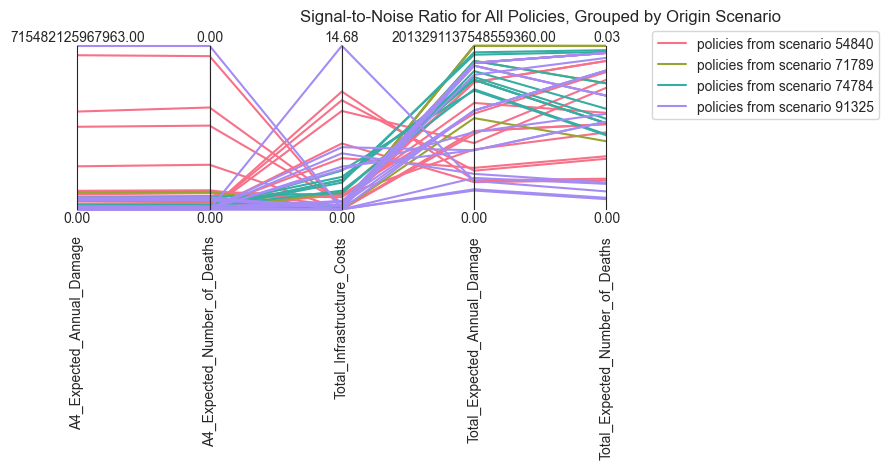

In [11]:
colors = sns.color_palette("husl", len(scenarios))
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for count, scenario in enumerate(scenarios):

    data = snr_scores[scenario]
    paraxes.plot(data, color=colors[count], label='policies from scenario ' + original_scenarios[count])
        
    plt.title(f'Signal-to-Noise Ratio for All Policies, Grouped by Origin Scenario')
    
paraxes.legend()

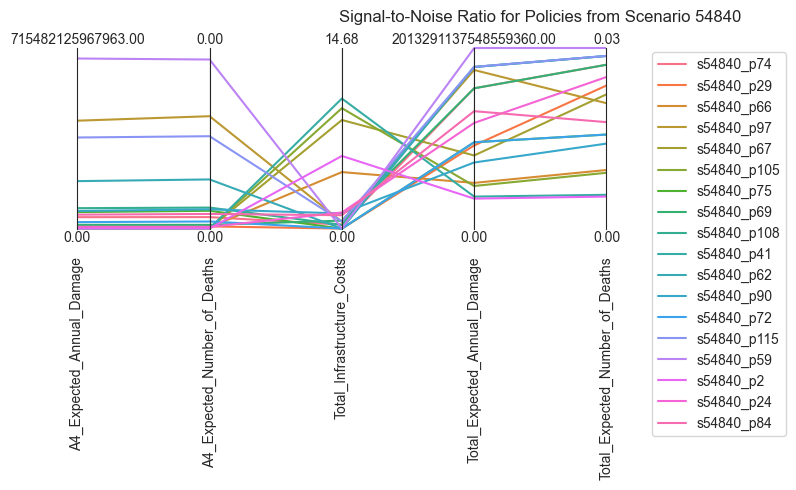

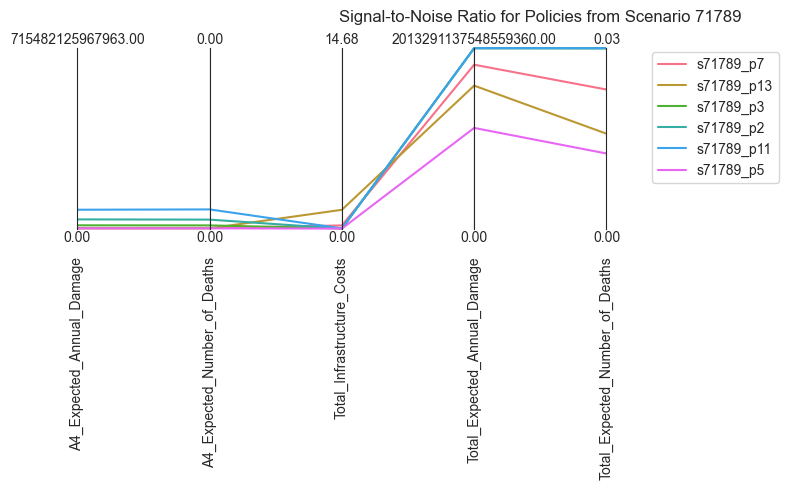

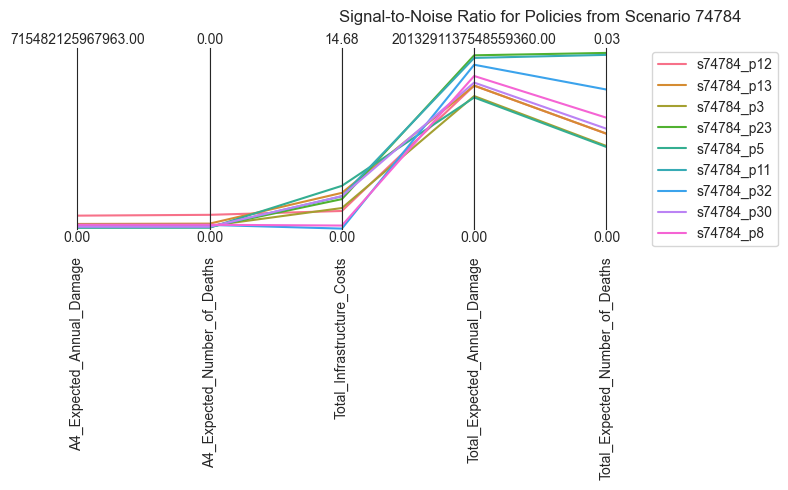

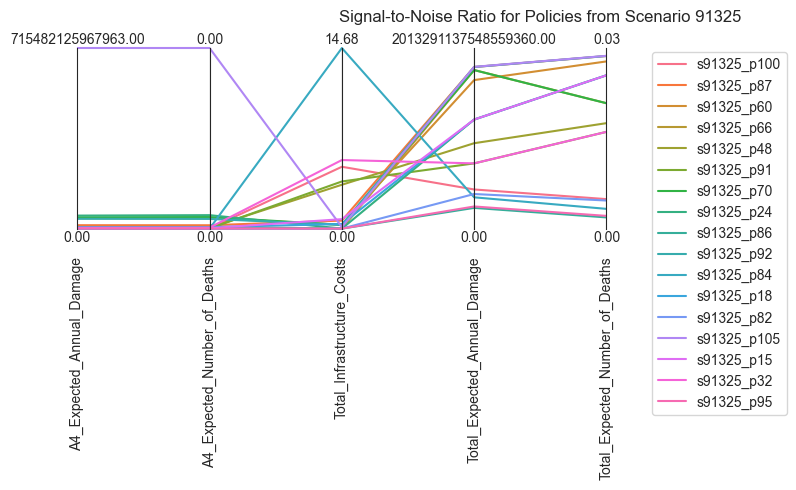

In [12]:
for scenario in scenarios:
        
    data = snr_scores[scenario]

    colors = sns.color_palette("husl", data.shape[0])
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

    paraxes.legend()
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}')
    plt.show()

#### Exploring which levers are used by candidate policies

In [13]:
# Creates a DataFrame containing all policies and the policy levers they activate

list(experiments.columns)
lever_start = experiments.columns.get_loc('EWS_DaysToThreat')
lever_end = experiments.columns.get_loc('A5_DikeIncrease_t2')
policy_levers = experiments.iloc[: , lever_start:lever_end]
policy_levers['policy'] = experiments['policy']
policy_levers.head(3)

,EWS_DaysToThreat,rfr_0_t0,rfr_0_t1,rfr_0_t2,rfr_1_t0,rfr_1_t1,rfr_1_t2,rfr_2_t0,rfr_2_t1,rfr_2_t2,...,A2_DikeIncrease_t2,A3_DikeIncrease_t0,A3_DikeIncrease_t1,A3_DikeIncrease_t2,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,policy
0,3,0,0,0,0,0,0,1,0,0,...,0,3,0,0,9,0,0,0,0,s91325_p100
1,3,0,0,0,0,0,0,1,0,0,...,0,3,0,0,9,0,0,0,0,s91325_p100
2,3,0,0,0,0,0,0,1,0,0,...,0,3,0,0,9,0,0,0,0,s91325_p100


In [14]:
all_data = pd.DataFrame()

for count, scenario in enumerate(scenarios):
    data = snr_scores[scenario]
    data['scenario'] = count
    all_data = pd.concat([all_data, data])

all_data.head(3)

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,scenario
s54840_p74,4.526318e+13,1.232083e-07,0.315831,1.564667e+18,0.025815,0
s54840_p29,8.224101e+12,2.372459e-08,0.000000,9.272904e+17,0.022542,0
s54840_p66,4.230448e+12,1.373347e-08,4.593787,5.097826e+17,0.009232,0


In [15]:
candidate_policies = all_data.reset_index()
candidate_policies = candidate_policies.iloc[:,0]
candidate_policies = candidate_policies.tolist()

In [16]:
#Returns a sorted Dataframe, with all levers that are used at least once as columns, and all policies as rows

all_levers = pd.DataFrame()

for policy in candidate_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    all_levers = pd.concat([all_levers, df])

all_levers = all_levers.reindex(sorted(all_levers.columns), axis=1)
all_levers.set_index('policy', inplace=True)
all_levers.head()

,A1_DikeIncrease_t0,A1_DikeIncrease_t1,A1_DikeIncrease_t2,A2_DikeIncrease_t0,A2_DikeIncrease_t1,A3_DikeIncrease_t0,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A5_DikeIncrease_t0,EWS_DaysToThreat,rfr_2_t0,rfr_2_t1,rfr_2_t2
policy,,,,,,,,,,,,,
s54840_p74,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4,NaN,NaN,NaN
s54840_p29,3.0,NaN,NaN,2.0,NaN,NaN,6.0,NaN,NaN,3,NaN,NaN,NaN
s54840_p66,3.0,NaN,NaN,3.0,NaN,2.0,7.0,NaN,2.0,4,NaN,NaN,NaN
s54840_p97,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4,NaN,1.0,NaN
s54840_p67,3.0,NaN,NaN,5.0,NaN,NaN,8.0,NaN,3.0,4,NaN,NaN,NaN


## Filtering out the bottom 50% in terms of A4 Expected Annual Damage SNR score

In [17]:
all_data = all_data.drop(all_data['A4_Expected_Annual_Damage'].nlargest(25).index)

In [18]:
limits = parcoords.get_limits(all_data)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = all_data[outcome].max()
limits = limits.drop(columns=['scenario'])
limits

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.00000
1,8.224101e+12,2.372459e-08,14.679912,1.932468e+18,0.02768


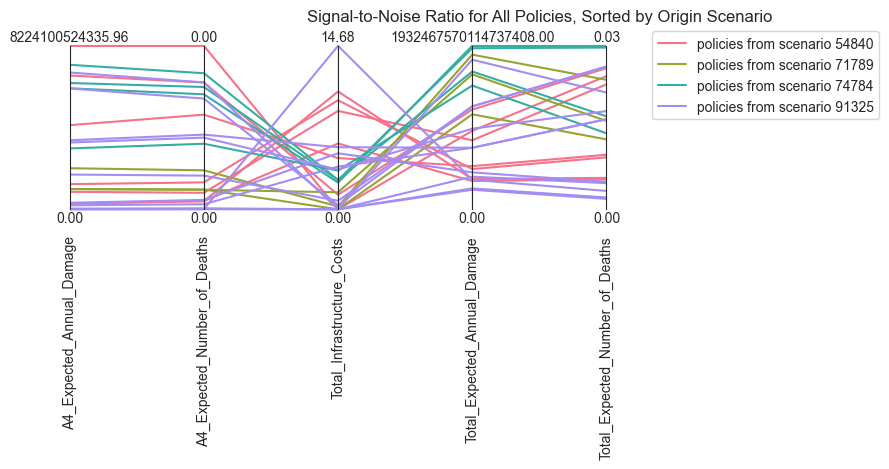

In [19]:
colors = sns.color_palette("husl", len(scenarios))
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for count, scenario in enumerate(scenarios):

    data = all_data[all_data['scenario'] == count]
    paraxes.plot(data, color=colors[count], label='policies from scenario ' + original_scenarios[count])
        
    plt.title(f'Signal-to-Noise Ratio for All Policies, Sorted by Origin Scenario')
    
paraxes.legend()

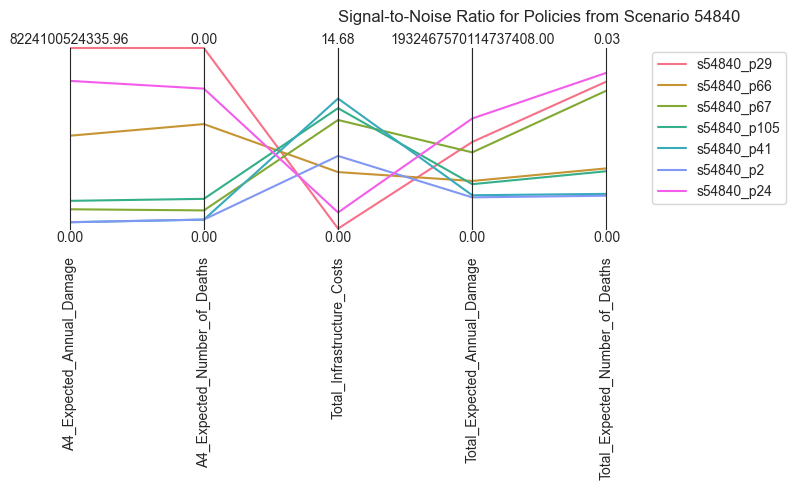

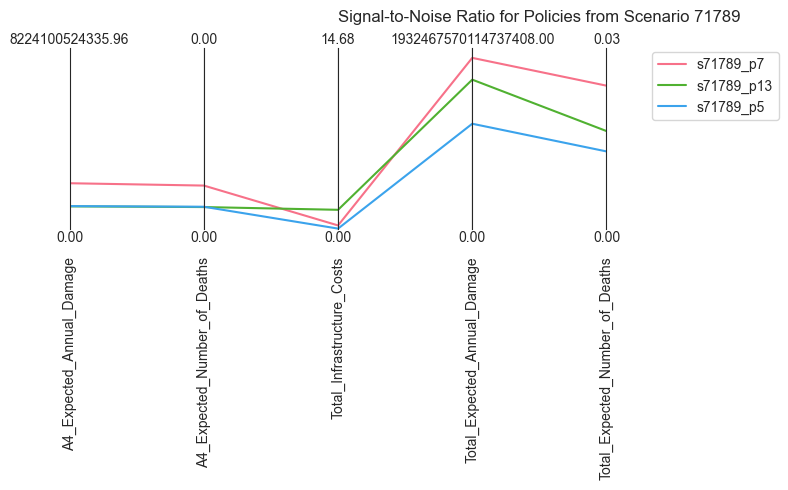

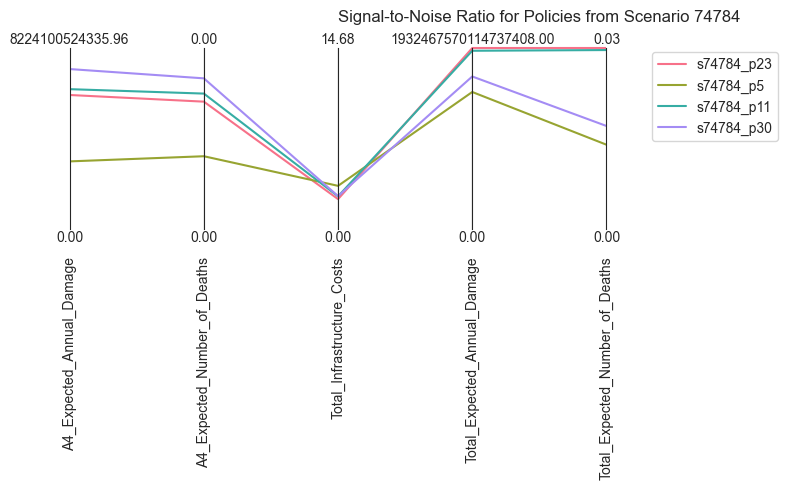

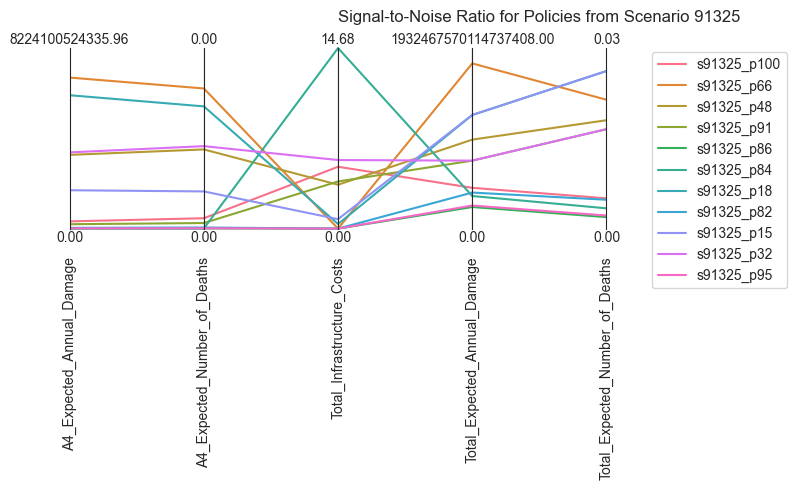

In [20]:
for count, scenario in enumerate(scenarios):
        
    data = all_data[all_data['scenario'] == count]

    # sns.color_palette() has 10 colors.
    colors = sns.color_palette("husl", data.shape[0])
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    #TODO: maybe enable printing the legend
    paraxes.legend()
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}')
    plt.show()

In [21]:
#Creates a list of all remaining policies after initial filtering

remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

In [22]:
#Returns all columns with non-zero values
remaining_levers = pd.DataFrame()

for policy in remaining_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    remaining_levers = pd.concat([remaining_levers, df])

remaining_levers = remaining_levers.reindex(sorted(remaining_levers.columns), axis=1)
remaining_levers.set_index('policy', inplace=True)
remaining_levers.head()

,A1_DikeIncrease_t0,A2_DikeIncrease_t0,A2_DikeIncrease_t1,A3_DikeIncrease_t0,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A5_DikeIncrease_t0,EWS_DaysToThreat,rfr_2_t0,rfr_2_t1,rfr_2_t2
policy,,,,,,,,,,,
s54840_p29,3.0,2.0,NaN,NaN,6,NaN,NaN,3,NaN,NaN,NaN
s54840_p66,3.0,3.0,NaN,2.0,7,NaN,2.0,4,NaN,NaN,NaN
s54840_p67,3.0,5.0,NaN,NaN,8,NaN,3.0,4,NaN,NaN,NaN
s54840_p105,3.0,4.0,NaN,2.0,8,NaN,3.0,3,NaN,NaN,NaN
s54840_p41,3.0,5.0,NaN,3.0,9,NaN,4.0,3,NaN,NaN,NaN


In the DataFrame above, the policy levers that were activated to create each of the remaining candidate policies can be seen. Notably, each candidate policy raises the dike for A4 by at least 60cm at timestep 0.

---------------------

## Maximum Regret


In [23]:
# helper function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

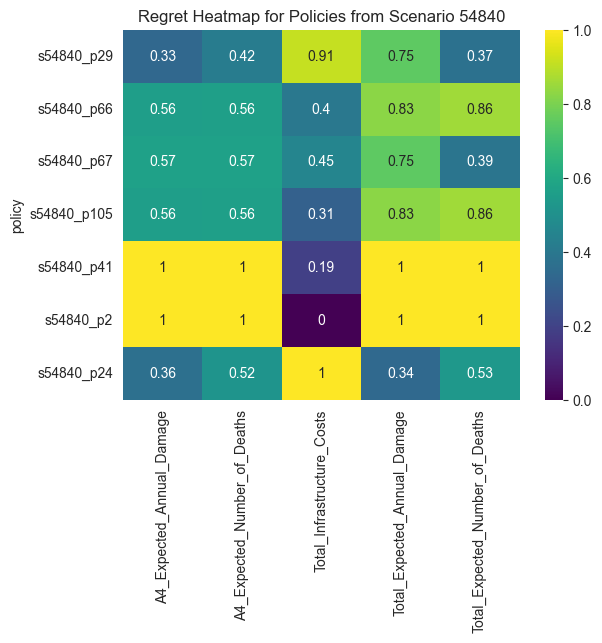

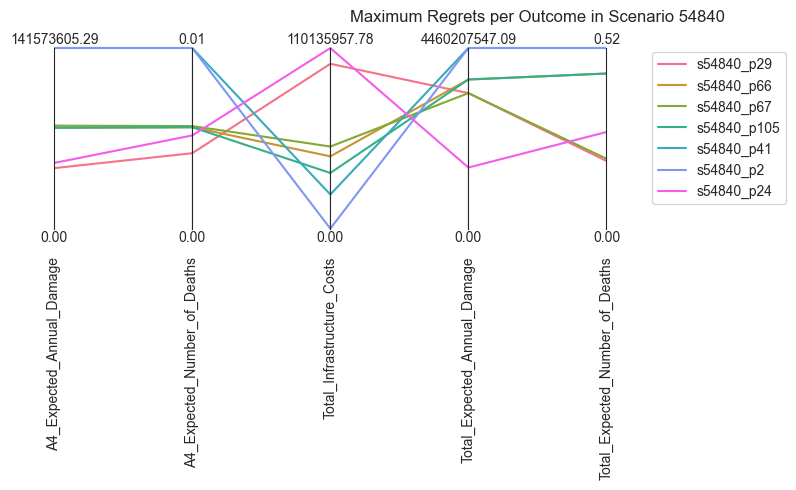

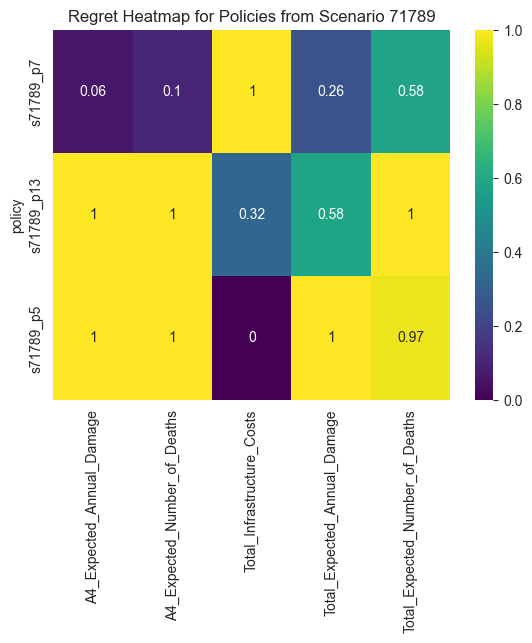

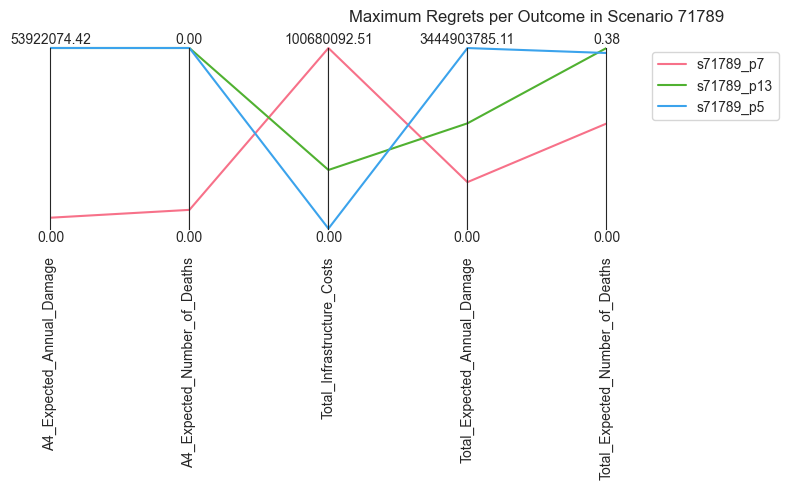

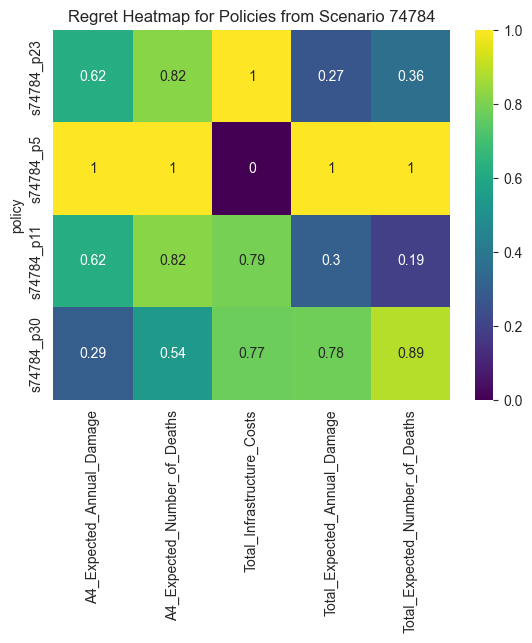

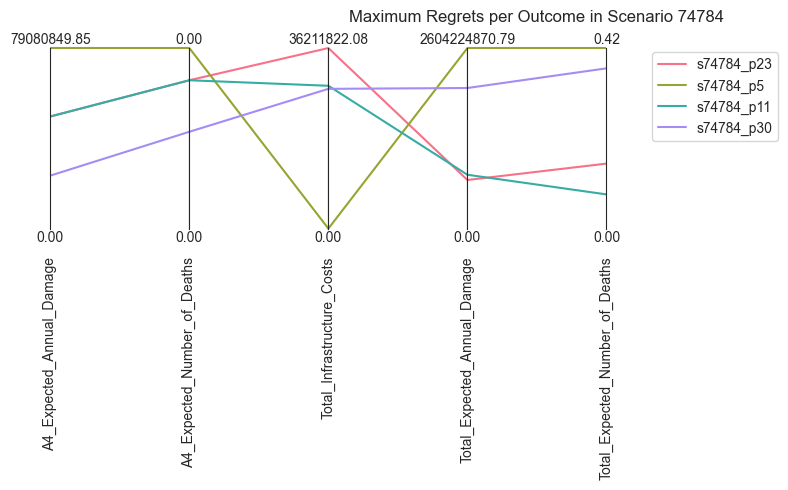

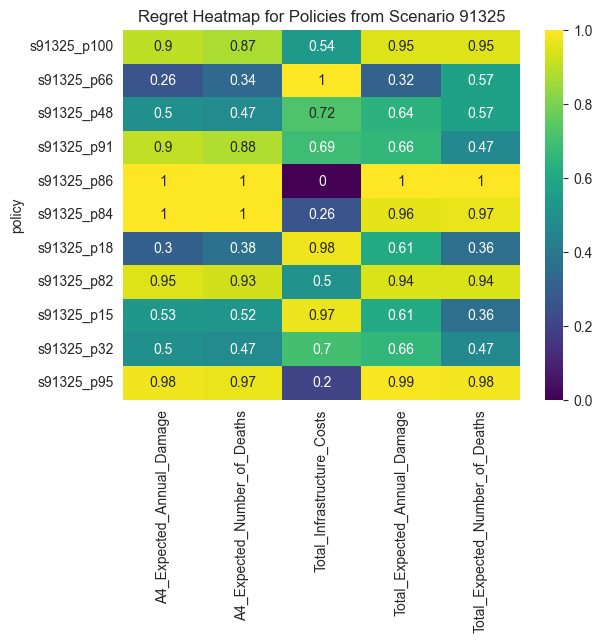

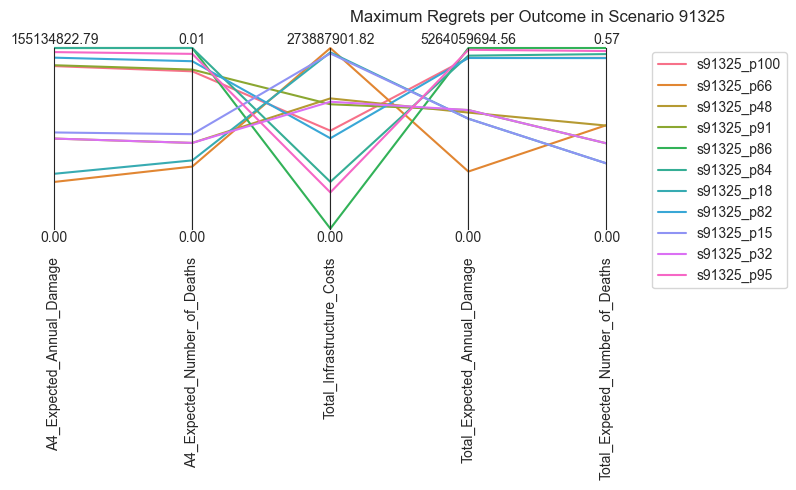

In [24]:
# generation of regret df

for scenario in scenarios:
    #if len(nondominated_policies[scenario]) < 2:
    #    continue

    all_regrets = {}
    max_regret = {}
    for outcome in model.outcomes:
        experiments_df = experiments_by_scenario[scenario]
        outcomes_dict = outcomes_by_scenario[scenario]
        # create a DataFrame with all the relevent information
        # i.e., policy, scenario_id, and scores
        data = pd.DataFrame({
            outcome.name : outcomes_dict[outcome.name], 
            "policy" : experiments_df['policy'],
            "robustness_scenario" : experiments_df['scenario'],
        })
        
        # Filter out rows that are not for policies kept according to signal to noise ratio. 
        data = data[data['policy'].isin(remaining_policies)]

        # reorient the data by indexing with policy and scenario id
        data = data.pivot(index='robustness_scenario', columns='policy')

        data.columns = data.columns.get_level_values(1)
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        all_regrets[outcome.name] = outcome_regret
        max_regret[outcome.name] = outcome_regret.max()

    # plotting regret heatmap
    max_regret = pd.DataFrame(max_regret)
    sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
    plt.title(f'Regret Heatmap for Policies from Scenario {scenario}')
    plt.show()
    # Max regret visualisation

    data = max_regret

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette("husl", data.shape[0])
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Maximum Regrets per Outcome in Scenario {scenario}')
        
    plt.show()

### Combining results from the second round of SNR, max regret, and considering diversity of policy levers

After inspecting the visualizations above, the following conclusions were drawn *Note that we are only looking within origin scenarios to easily (and visually) identify dominance within a smaller selection of the candidate policy set.*:

In terms of SNR:
- s54840_p2 dominates 67, 41, 105
- s71789_p5 dominates 7 and 13
- s74784_p5 performs very well across the board compared to others within its scenario, though having a higher infra cost. The others have mildly interesting trade-offs but are much worse.
- s91325_p86 practically dominates everything -- but barely dominates 95

In terms of Max regret:

- s54840 shows no policy that is dominant. The largest trade-off is clearly visible in total infrastructure costs, which is balanced by all other outcomes combined. Policies that perform well on infra costs, perform poorly elsewhere and vice-versa. However, 66 and 67 thread the needle, performing decently on all outcomes but not stellar anywhere
- s71789 shows three policies with diverse trade-offs. Note that p5 performs well in SNR, but only performs well in terms of infra costs for the max regret metric
- s74784 - p11 beats out p23 for our purposes. A minor increased in expected overall damages is offset by fewer deaths and far lower infra costs
- s91325 - p18 and p14 are dominated. p32 and p48 perform very similarly. Likewise p82 and p100 perform similarly

In terms of policy lever diversity:
- s54 - no RfR, always a strategy with much overall dike heightening
- s717 - 13 and 5 have RfR projects, 7 13 5 little other dike support
- s74 - 30 RfR and little other dike support
- s91 - 100 66 86 84 RfR projects, 66, 18, 15 offer little other dike support. 86 84 95 see further A4 dike raising at t1
  
- EWS is 3-4 across the board
- A4 dike increase at t0 is 60cm or higher aross the board

 All in all, to keep a diverse set and re-evaluate, the following policies are dropped:
 - s54840:
    - p67, as it's similar to d66 in terms of regret and dominated by p2 in terms of SNR.
    - p41, as it is dominated and otherwise uninteresting in terms of levers or regret
 - s71789:
    - p7, as p13 is kept for similarly interesting policy levers, but are both not great performers
 - s74784:
    - p23, No interesting levers and otherwise outperformed
 - s91325:
    - p15, dominated in snr, uninteresting
    - p18, dominated, uninteresting
    - p32, performs similarly to p48
    - p84, similar to other policies
    - p82, dominated by s54840_p2


In [25]:
drop_list = ['s54840_p67', 's54840_p41', 's71789_p7', 's74784_p23', 's91325_p15', 's91325_p18', 's91325_p32', 's91325_p84',
            's91325_p82']
for policy in drop_list:
    all_data = all_data.drop([policy])

#Creates a list of all remaining policies after initial filtering

remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

for policy in remaining_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    remaining_levers = pd.concat([remaining_levers, df])

remaining_levers = remaining_levers.reindex(sorted(remaining_levers.columns), axis=1)
remaining_levers.set_index('policy', inplace=True)

### Plotting once more

In [26]:
limits = parcoords.get_limits(all_data)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = all_data[outcome].max()
limits = limits.drop(columns=['scenario'])

SNS:

Text(0.5, 1.0, 'Signal to Noise Ratio per Outcome for All Remaining Candidate Policies')

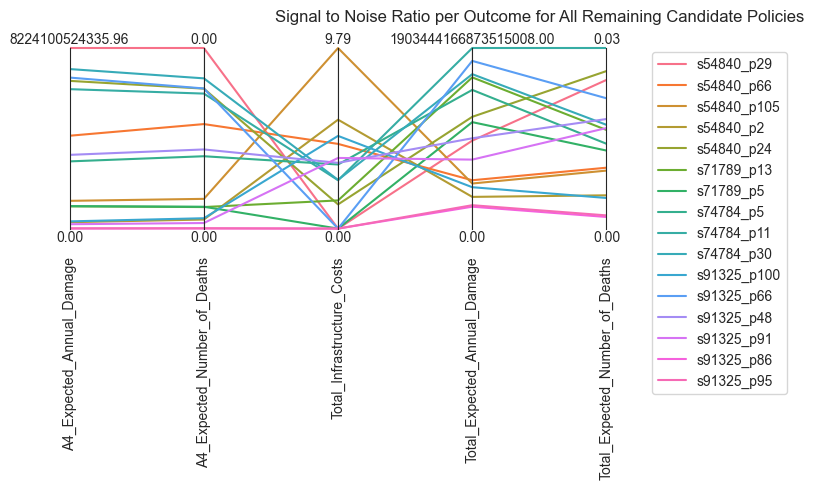

In [27]:
colors = sns.color_palette("husl", all_data.shape[0])
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(all_data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Signal to Noise Ratio per Outcome for All Remaining Candidate Policies')

Max regret:

Text(0.5, 1.0, 'Maximum Regrets per Outcome for All Remaining Candidate Policies')

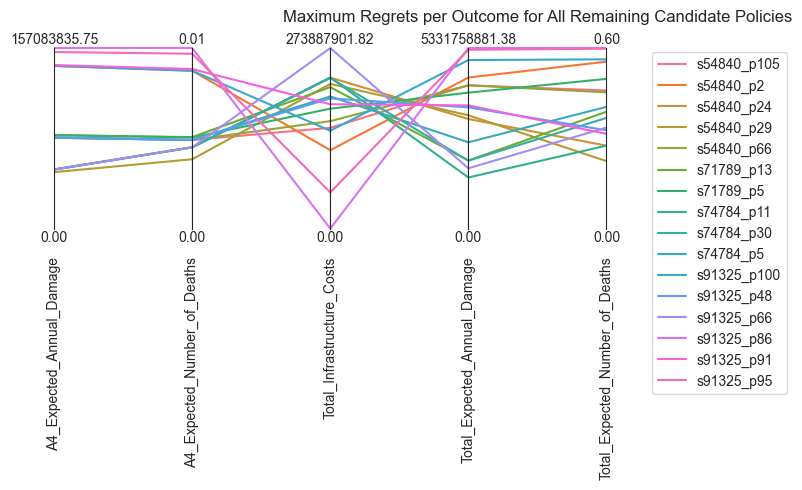

In [28]:
all_regrets = {}
max_regret = {}

for outcome in model.outcomes:
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data[data['policy'].isin(remaining_policies)]
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    all_regrets[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

#sorting dataframe by index
max_regret = pd.DataFrame(max_regret)
data = max_regret
data = data.sort_index()
    
# plotting regret heatmap

#sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
#plt.title(f'Regret Heatmap for All Remaining Policies')
#plt.show()

#plotting parallel plots

limits = parcoords.get_limits(data)
limits.loc[0, outcomes_of_interest] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    colors = sns.color_palette("husl", data.shape[0])
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Maximum Regrets per Outcome for All Remaining Candidate Policies')

### Final cut
The two top performers overall, while being internally diverse in terms of policy levers:
- s91325_p95
- s91325_p86

Strong performer that has solid robustness across all metrics taking a middle approach
- s54840_p2

Alternative strategy focusing only on mild dike raising for and RfR projects
- s91324_p100

Note that the first two options are clear winners in terms of snr ratio, indicating consistent policies that provide safety through large initial investments in dike raising across the board. Notably,s91325_p86 employs RfR2, while s91325_p95 relies solely on dikes. The third option offers a sub-optimal solution in all cases, but proves to be safer and more robust in a wide range of uncertainty parameters. This too is a dike-based strategy. The final option performs the worst across the board in terms of the quantitative outcomes of the model. However, it is an attractive option where the focus lies on nature preservation and less reliance on dikes.

In [29]:
final_policies = ['s91325_p86', 's91325_p95', 's54840_p2', 's91325_p100']
all_data = all_data.loc[final_policies]
remaining_levers = remaining_levers.loc[final_policies]

#Creates a list of all remaining policies after initial filtering

remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()



In [30]:
remaining_policies

['s91325_p86', 's91325_p95', 's54840_p2', 's91325_p100']

In [31]:
remaining_levers

,A1_DikeIncrease_t0,A2_DikeIncrease_t0,A2_DikeIncrease_t1,A3_DikeIncrease_t0,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A5_DikeIncrease_t0,EWS_DaysToThreat,rfr_2_t0,rfr_2_t1,rfr_2_t2
policy,,,,,,,,,,,
s91325_p86,3.0,5.0,2.0,4.0,10,7.0,5.0,3,NaN,1.0,1.0
s91325_p95,3.0,6.0,3.0,6.0,10,2.0,4.0,3,NaN,NaN,NaN
s54840_p2,3.0,7.0,NaN,3.0,9,NaN,6.0,3,NaN,NaN,NaN
s91325_p100,3.0,4.0,NaN,3.0,9,NaN,NaN,3,1.0,NaN,NaN


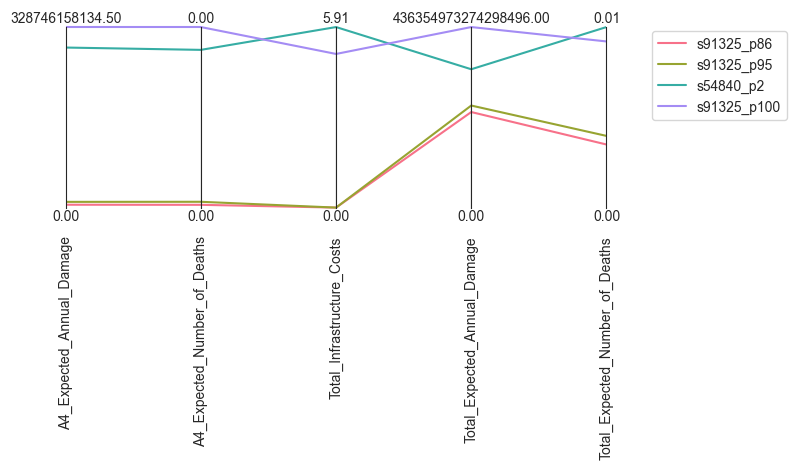

In [32]:
limits = parcoords.get_limits(all_data)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = all_data[outcome].max()
limits = limits.drop(columns=['scenario'])

colors = sns.color_palette("husl", all_data.shape[0])
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(all_data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()

Text(0.5, 1.0, 'Max regret parallel plot')

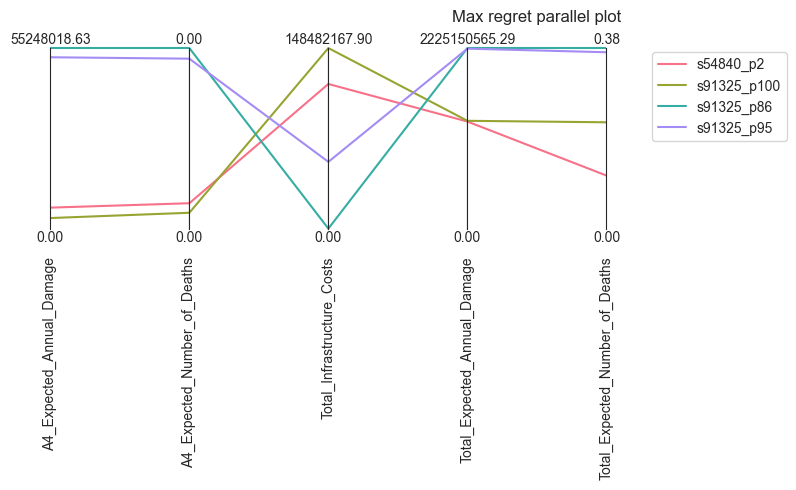

In [33]:
all_regrets = {}
max_regret = {}

for outcome in model.outcomes:
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data[data['policy'].isin(remaining_policies)]
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    all_regrets[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

#sorting dataframe by index
max_regret = pd.DataFrame(max_regret)
data = max_regret
data = data.sort_index()
    
# plotting regret heatmap

#sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
#plt.title(f'Regret Heatmap for All Remaining Policies')
#plt.show()

#plotting parallel plots

limits = parcoords.get_limits(data)
limits.loc[0, outcomes_of_interest] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    colors = sns.color_palette("husl", data.shape[0])
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Max regret parallel plot')